# Analisis Exploratorio de Datos de PE La Castellana

In [94]:
import sys 
print(sys.version)

3.8.18 (default, Sep 11 2023, 13:39:12) [MSC v.1916 64 bit (AMD64)]


In [95]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.arima_model import ARIMA

import pmdarima as pm
from pmdarima.arima.utils import ndiffs

from pandas.plotting import autocorrelation_plot, lag_plot
from scipy import signal
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error
from numpy import log

from dateutil.parser import parse 

import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'figure.figsize': (21,7), 'figure.dpi':120})
%matplotlib inline

import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats


## meteostat
from datetime import datetime
from shapely.geometry import Point
from meteostat import Hourly

##mis funciones
#from datetime import timedelta #si no se define dentro de la funcion arroja error
from clean_data import remover_valores_repetidos
from clean_data import rango_fechas_repe
from clean_data import rango_fechas_repe_exc
from clean_data import weighted_circular_mean



El dataset que se va a trabajar corresponde al Parque Eólico Achiras (localizado en Cordoba).

In [96]:
# Custom date parsing function for the "Date" column
def custom_date_parser(date_string):
    return pd.to_datetime(date_string, format='%d/%m/%Y %H:%M')

#path = 'https://raw.githubusercontent.com/guilledesimone/MMA/main/Datos_LAC_SOTR_2019_2024_horario.csv'
path = 'D:\\Documents\\MMA\\1.0 Tesis\\Datos\\Datos_LAC_SOTR_2019_2024_horario.csv'


data_types = {          
    'TotPwrWTGs': float,        
    'Nro_Available_WTGs': float,
    'VelViento': float,
    'DirVientoPond': float,
    'Temp': float,
    'HumedadRel': float,
    'PresionAtm': float
    ,'ENERGIA_SMEC': float
    ,'ENERGIA_PRON_CAMMESA': float
    ,'ERROR_PRONOSTICO': float
}


# Read the CSV file with semicolon as delimiter, specifying the custom date parser
df = pd.read_csv(path, dtype=data_types,decimal=',', parse_dates=['FechaHora'], 
                 date_parser=custom_date_parser, delimiter=';', header=0)

#daba error al leer el csv por que tenia un punto como separador de miles en un valor de la columna ERROR_PRONOSTICO

#### Descripción del dataset
Este dataset corresponde a los datos producción de generación de energia y los meteorológicos del parque eólico Achiras ubicado en la provincia de Cordoba Argentina. El parque tiene una potencia instalada de 48 Mw.

El dataset cuenta con datos desde Enero del 2019 a la actualidad.  


#### Descripción de las variables del dataset
* TotPwrWTGs: Es la suma de la energia horaria generada por cada turbina del parque. Fuente sistema Scada del parque        
* Nro_Available_WTGs: Es un contador de turbinas que estan en un estado de indisponibilidad, se infiere este estado por estar consumiendo energia auxiliar (valores de potencia en 0 o negativos)
* VelViento: Velocidad promedio del viento horaria. Fuente Estación meteorologica del parque. 
* DirVientoPond: Dirección del viento horaria promedio ponderado con la velocidad del viento.   
* Temp: Temperatura ambiente promedio horario. Fuente Estación meteorologica del parque.
* HumedadRel: Humedad promedio horaria. Fuente Estación meteorologica del parque.
* PresionAtm: Presion atmosféria horaria. Fuente Estación meteorologica del parque.   
* ENERGIA_SMEC: Es la energia horaria neta producida medida por el medidor de energia del parque. Es por la que remunera Cammesa o el cliente. Es un poco menor que la TotPwrWTGs por que resta la energia auxiliar consumida por la propia planta para producir.   
* ENERGIA_PRON_CAMMESA: Es la energia pronosticada por Cammesa que se va a producir en la planta. 
* ERROR_PRONOSTICO: Es el error del pronostico, diferencia entre ENERGIA_SMEC y ENERGIA_PRON_CAMMESA

Estas últimas 3 variables provienen de la base de datos de Cammesa y la ENERGIA_SMEC esta garantizado que es un dato de calidad por que se interroga directamente desde el medidor de energia y se utiliza para facturar.

In [97]:
#cambio nombre de las columnas


nom_colum = ['FechaHora','EnergiaTGW','AerosDisp','VelViento','DirViento','TempAmb','HumedadRel','PresionAtm','EnergiaSMEC','PronosticoCammesa','ErrorPronostico']

df.columns = nom_colum

df.head(5)

,FechaHora,EnergiaTGW,AerosDisp,VelViento,DirViento,TempAmb,HumedadRel,PresionAtm,EnergiaSMEC,PronosticoCammesa,ErrorPronostico
0,2019-01-30 13:00:00,48.41,17.50,9.51,199.99,-49.68,0.95,1001.95,72.84,NaN,NaN
1,2019-01-30 14:00:00,64.37,27.83,9.67,197.27,-49.68,0.95,1002.07,63.27,NaN,NaN
2,2019-01-30 15:00:00,65.63,28.67,9.05,194.93,-49.68,0.95,1002.08,64.52,NaN,NaN
3,2019-01-30 16:00:00,56.08,30.33,8.48,183.57,-49.68,0.95,1002.30,55.24,NaN,NaN
4,2019-01-30 17:00:00,40.21,31.83,7.39,166.49,-49.68,0.95,1002.54,39.72,NaN,NaN


### Prueba para un rango reducido

In [98]:
#Prueba para filtrar 2 meses
# Prueba con un lote de 2 meses oct y nov 2023

#descomomentar lo de abajo

#start_date = datetime(2023, 10, 1)
#end_date = datetime(2023, 11, 30)

#filtered_df = df[(df['FechaHora'] >= start_date) & (df['FechaHora'] <= end_date)]
#df=filtered_df 

#df.reset_index(drop=True, inplace=True) #quitar despues de la prueba

#### Limpieza de datos

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41595 entries, 0 to 41594
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   FechaHora          41595 non-null  datetime64[ns]
 1   EnergiaTGW         41571 non-null  float64       
 2   AerosDisp          41595 non-null  float64       
 3   VelViento          41571 non-null  float64       
 4   DirViento          41571 non-null  float64       
 5   TempAmb            41571 non-null  float64       
 6   HumedadRel         41571 non-null  float64       
 7   PresionAtm         41571 non-null  float64       
 8   EnergiaSMEC        41595 non-null  float64       
 9   PronosticoCammesa  29753 non-null  float64       
 10  ErrorPronostico    29753 non-null  float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 3.5 MB


#### Verficación de valores nulos

In [100]:
df.isnull().sum()

FechaHora                0
EnergiaTGW              24
AerosDisp                0
VelViento               24
DirViento               24
TempAmb                 24
HumedadRel              24
PresionAtm              24
EnergiaSMEC              0
PronosticoCammesa    11842
ErrorPronostico      11842
dtype: int64

El valor a predecir es el de EnergiaSMEC, como se puede observar para las variables meteorológicas hay 77 valores en null y ademas debo analizar la calidad de las variables meteorológicas para detectar inconsistencias. Esto implica que hubo un problema de comunicación con la estación meteorologica o con alguno de los sensores.  

#### Analisis de inconsistencias en variable meteorológicas

In [101]:
num_vars= nom_colum[1:9]
df[num_vars].describe().T

,count,mean,std,min,25%,50%,75%,max
EnergiaTGW,41571.0,48.838497,35.301517,-0.63,15.130,45.41,85.140,101.58
AerosDisp,41595.0,26.666445,7.911393,0.00,25.830,30.00,31.000,32.00
VelViento,41571.0,7.224585,4.028501,0.00,4.240,6.96,10.180,23.78
DirViento,41571.0,220.256483,105.411433,0.00,124.895,249.80,316.275,359.86
TempAmb,41571.0,12.624911,16.935556,-49.75,9.790,15.43,21.205,122.46
HumedadRel,41571.0,53.553292,51.474063,-55.52,29.425,47.18,67.880,394.40
PresionAtm,41571.0,970.540397,173.350575,0.00,999.710,1003.87,1008.000,1024.66
EnergiaSMEC,41595.0,48.118923,34.768925,0.00,14.525,45.76,84.030,99.44


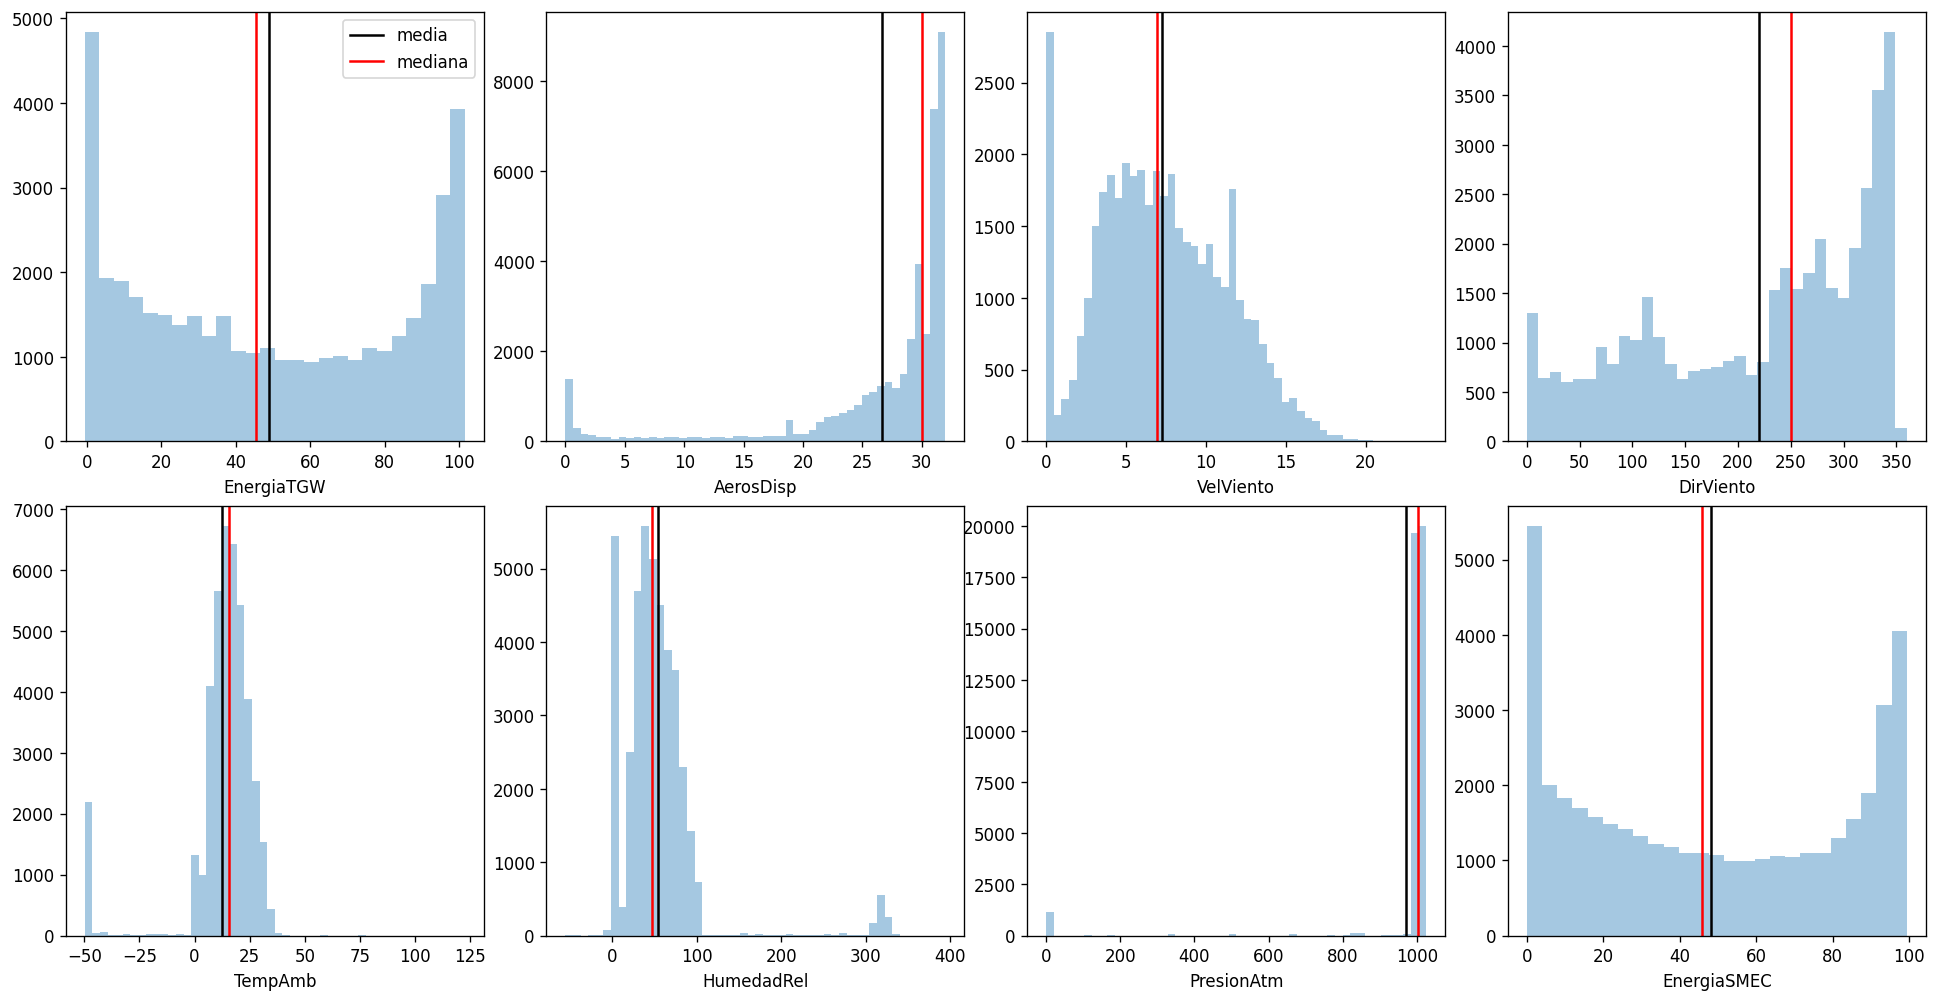

In [102]:
# Distribuciones para cada variable numerica
f,ax = plt.subplots(2,4,figsize=(20,10),gridspec_kw={'wspace':0.15,'hspace':0.15})

ax = ax.ravel()
for i,col in enumerate(num_vars):
    sns.distplot(df[col].astype(float),ax=ax[i],kde=False)
    ax[i].axvline(x=df[col].mean(),color='k',label='media')
    ax[i].axvline(x=df[col].median(),color='r',label='mediana')    
# Turn off the last subplot
if len(num_vars) < len(ax):
    ax[len(num_vars)].remove()
   
ax[0].legend();

In [103]:
df[num_vars].describe().T

,count,mean,std,min,25%,50%,75%,max
EnergiaTGW,41571.0,48.838497,35.301517,-0.63,15.130,45.41,85.140,101.58
AerosDisp,41595.0,26.666445,7.911393,0.00,25.830,30.00,31.000,32.00
VelViento,41571.0,7.224585,4.028501,0.00,4.240,6.96,10.180,23.78
DirViento,41571.0,220.256483,105.411433,0.00,124.895,249.80,316.275,359.86
TempAmb,41571.0,12.624911,16.935556,-49.75,9.790,15.43,21.205,122.46
HumedadRel,41571.0,53.553292,51.474063,-55.52,29.425,47.18,67.880,394.40
PresionAtm,41571.0,970.540397,173.350575,0.00,999.710,1003.87,1008.000,1024.66
EnergiaSMEC,41595.0,48.118923,34.768925,0.00,14.525,45.76,84.030,99.44


Como se puede observar hay valores inconsistentes por los picos y outliers en todas las variables meteorológicas

###### Calculo de los promedios de las variables meteorológicas en base a la EnergiaSMEC
Calculos los valores promedio de las variables meteotológicas para valores discretizados con saltos de 0,5 MW de la variable EnergiaSMEC

Para calcular los valores promedio de las variables meteorológicas elimino los nulos y los valores inconsistentes, que distorcionan el calculo de la media

In [104]:
#variables meteorológicas
meteo_vars=['VelViento','DirViento','TempAmb','HumedadRel','PresionAtm']

In [105]:
#Borro los registros que tiene valor nulo
df_aux=df.dropna(subset=['EnergiaTGW'])

In [106]:
#Verifico que no quedan nulos
df_aux.isnull().sum()

FechaHora                0
EnergiaTGW               0
AerosDisp                0
VelViento                0
DirViento                0
TempAmb                  0
HumedadRel               0
PresionAtm               0
EnergiaSMEC              0
PronosticoCammesa    11832
ErrorPronostico      11832
dtype: int64

In [107]:
#remuevo los registros que tiene valores repetidos para la VelViento durante 3 horas consecutivas
df_aux=remover_valores_repetidos(df_aux, 'FechaHora', 'VelViento', 3,'n')

Se removieron 7340 registros repetidos


In [108]:
#Elimino los registros de outliers de TempAmb
df_aux.drop(df_aux[(df_aux['TempAmb'] <= -5) | (df_aux['TempAmb'] >= 42)].index, inplace=True)

#Elimino los registros de outliers de PresionAtm
df_aux.drop(df_aux[(df_aux['PresionAtm'] <= 800) | (df_aux['PresionAtm'] >= 1200)].index, inplace=True)

#Elimino los registros de outliers de HumedadRel
#df_aux.drop(df_aux[(df_aux['HumedadRel'] <= 0) | (df_aux['HumedadRel'] >= 100)].index, inplace=True)

#Elimino los registros cuando todas las variables meteorologicas son 0
df_aux.drop(df_aux[(df_aux[meteo_vars] == 0).all(axis=1)].index, inplace=True)


In [109]:
#Reviso minimos y maximos de las variables 
df_aux[num_vars].describe().T

,count,mean,std,min,25%,50%,75%,max
EnergiaTGW,31526.0,48.854182,35.493345,-0.63,14.7400,46.050,85.3800,101.57
AerosDisp,31526.0,26.716718,7.911351,0.00,26.0000,30.000,31.0000,32.00
VelViento,31526.0,7.720993,3.703129,0.00,4.8200,7.230,10.3500,23.78
DirViento,31526.0,224.693759,100.446633,0.00,135.2725,252.520,315.3400,359.86
TempAmb,31526.0,17.383546,7.121009,-4.39,12.0800,17.005,22.2900,40.93
HumedadRel,31526.0,58.461459,52.879782,-55.52,33.8300,49.370,67.8800,394.40
PresionAtm,31526.0,1003.427137,13.001832,800.79,1000.2400,1004.100,1008.0700,1024.66
EnergiaSMEC,31526.0,47.892441,34.768206,0.00,14.3300,45.315,83.8075,99.44


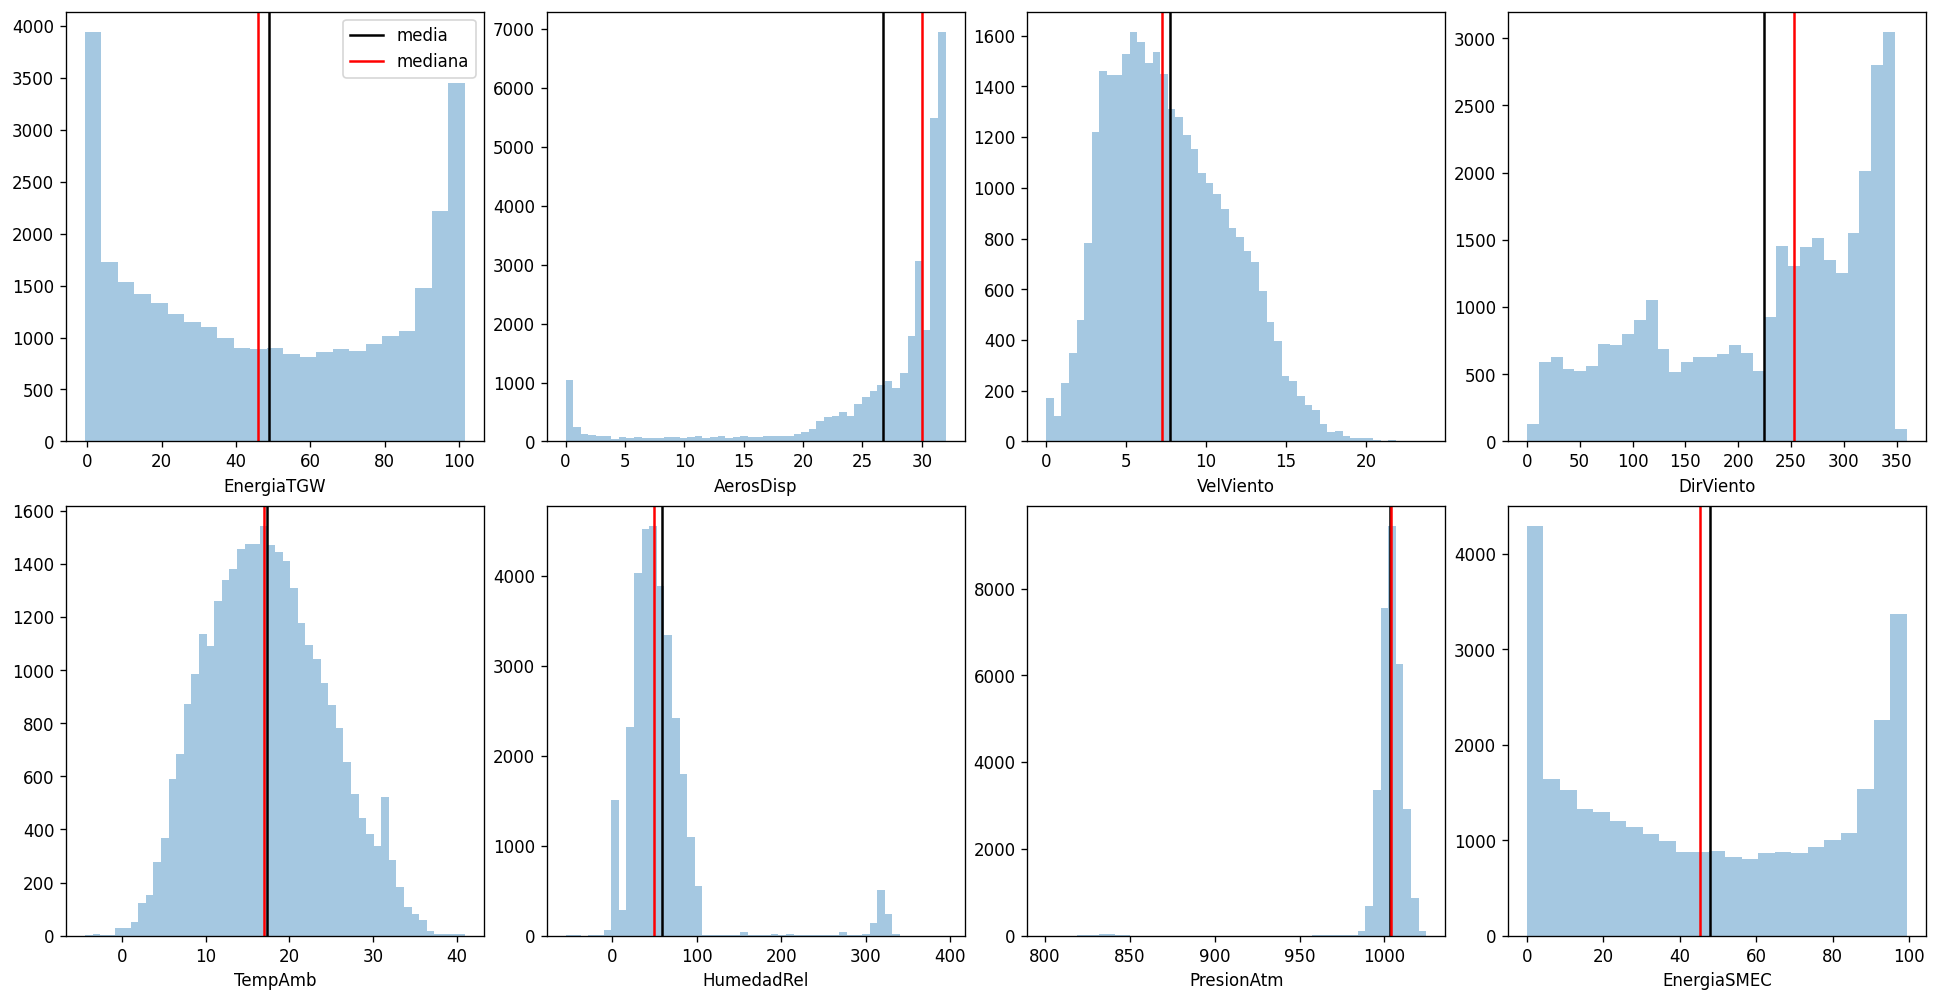

In [110]:
# Distribuciones para cada variable numerica
f,ax = plt.subplots(2,4,figsize=(20,10),gridspec_kw={'wspace':0.15,'hspace':0.15})

ax = ax.ravel()
for i,col in enumerate(num_vars):
    sns.distplot(df_aux[col].astype(float),ax=ax[i],kde=False)
    ax[i].axvline(x=df_aux[col].mean(),color='k',label='media')
    ax[i].axvline(x=df_aux[col].median(),color='r',label='mediana')    
# Turn off the last subplot
if len(num_vars) < len(ax):
    ax[len(num_vars)].remove()
   
ax[0].legend();

Luego de remover valores inconsistentes y outliers, no se observan en los histogramas outliers o picos que respondan a anomalias

##### Calculo de los promedios de las variables meteorológicas

In [111]:
# Discretizo la EnergiaSMEC con pasos de 0.5 MW
df['EnergiaSMEC_discreta'] = df['EnergiaSMEC'].apply(lambda x: round(x * 2) / 2)
df_aux['EnergiaSMEC_discreta'] = df_aux['EnergiaSMEC'].apply(lambda x: round(x * 2) / 2)

In [112]:
# Calculo la media de cada columna basado en los valores discretos de EnergiaProd
df_meteo = df_aux[['EnergiaSMEC_discreta','VelViento','DirViento','TempAmb', 'HumedadRel', 'PresionAtm']]

df_mean_meteo = df_meteo.groupby('EnergiaSMEC_discreta').mean().reset_index()

df_count_meteo = df_meteo.groupby('EnergiaSMEC_discreta').count().reset_index()

In [113]:
# Calcula el promedio circular ponderado por la VelViento agrupando por EnergySMEC
DirViento_grouped_means = df_meteo.groupby('EnergiaSMEC_discreta').apply(lambda x: weighted_circular_mean(x['DirViento'], x['VelViento']))

# Alinea la media calculada cob el index de df_mean_meteo
df_mean_meteo['DirViento'] = df_mean_meteo['EnergiaSMEC_discreta'].map(DirViento_grouped_means)


In [114]:
#df_mean_meteo

In [115]:
#df_count_meteo

In [116]:
# Realizo la unión de los DataFrames en base a las columna 'EnergiaSMEC_discreta'
merged_df = df.merge(df_mean_meteo, 
                 on=['EnergiaSMEC_discreta'], 
                 how='left', suffixes = ('', '_mean'))

In [117]:
#Imputo la media en los registros nulos
mask = merged_df[meteo_vars].isnull().all(axis=1)

# Imputo en los registors nulos de las variables meteorologicas los valores medios
merged_df.loc[mask, 'VelViento'] = merged_df.loc[mask, 'VelViento_mean']
merged_df.loc[mask, 'DirViento'] = merged_df.loc[mask, 'DirViento_mean']
merged_df.loc[mask, 'TempAmb'] = merged_df.loc[mask, 'TempAmb_mean']
merged_df.loc[mask, 'HumedadRel'] = merged_df.loc[mask, 'HumedadRel_mean']
merged_df.loc[mask, 'PresionAtm'] = merged_df.loc[mask, 'PresionAtm_mean']

# Imputo en los registors nulos de EnergiaTGW el valor medio 
merged_df['EnergiaTGW'].fillna(merged_df['EnergiaTGW'].mean(), inplace=True)


In [118]:
#verifico si quedo algun valor nulo
merged_df.isnull().sum()

FechaHora                   0
EnergiaTGW                  0
AerosDisp                   0
VelViento                   0
DirViento                   0
TempAmb                     0
HumedadRel                  0
PresionAtm                  0
EnergiaSMEC                 0
PronosticoCammesa       11842
ErrorPronostico         11842
EnergiaSMEC_discreta        0
VelViento_mean              0
DirViento_mean              0
TempAmb_mean                0
HumedadRel_mean             0
PresionAtm_mean             0
dtype: int64

In [119]:
# Utilizo la funcion rango_fechas_repe devuelve un data_range con los periodos de fecha 
# con valores repetidos en VelViento

dr=rango_fechas_repe(df, 'FechaHora', 'VelViento', 3,'y')

Valor 11.21 repetido 9 veces en las fechas: 2019-05-05 00:00:00 - 2019-05-05 08:00:00
Existen 7340 registros repetidos
Valor 3.55 repetido 12 veces en las fechas: 2019-05-07 21:00:00 - 2019-05-08 08:00:00
Existen 7340 registros repetidos
Valor 9.41 repetido 10 veces en las fechas: 2019-05-09 00:00:00 - 2019-05-09 09:00:00
Existen 7340 registros repetidos
Valor 4.07 repetido 17 veces en las fechas: 2019-05-09 18:00:00 - 2019-05-10 10:00:00
Existen 7340 registros repetidos
Valor 5.84 repetido 10 veces en las fechas: 2019-05-10 19:00:00 - 2019-05-11 04:00:00
Existen 7340 registros repetidos
Valor 6.68 repetido 3 veces en las fechas: 2019-05-11 06:00:00 - 2019-05-11 08:00:00
Existen 7340 registros repetidos
Valor 3.07 repetido 9 veces en las fechas: 2019-05-20 17:00:00 - 2019-05-21 01:00:00
Existen 7340 registros repetidos
Valor 3.07 repetido 4 veces en las fechas: 2019-05-21 05:00:00 - 2019-05-21 08:00:00
Existen 7340 registros repetidos
Valor 0.0 repetido 6 veces en las fechas: 2019-05-2

In [120]:
#Imputo el valor medio de las variables meteorologicas para los rangos de fechas donde 
#hay valores repetidos
for prev_value, rep_count, start, end in dr:
        # Filtro por el rango de fechas
        mask = (merged_df['FechaHora'] >= start) & (merged_df['FechaHora'] <= end)

        # Actualizo los valores medios
        merged_df.loc[mask, 'VelViento'] = merged_df.loc[mask, 'VelViento_mean']
        merged_df.loc[mask, 'DirViento'] = merged_df.loc[mask, 'DirViento_mean']
        merged_df.loc[mask, 'TempAmb'] = merged_df.loc[mask, 'TempAmb_mean']
        merged_df.loc[mask, 'HumedadRel'] = merged_df.loc[mask, 'HumedadRel_mean']
        merged_df.loc[mask, 'PresionAtm'] = merged_df.loc[mask, 'PresionAtm_mean']


In [121]:
#Imputo la media en los registros de outliers de TempAmb
mask = (merged_df['TempAmb'] <= -5) | (merged_df['TempAmb'] >= 40)

merged_df.loc[mask, 'TempAmb'] = merged_df.loc[mask, 'TempAmb_mean']

#Imputo media en los registros de outliers de PresionAtm
mask = (merged_df['PresionAtm'] <= 800) | (merged_df['PresionAtm'] >= 1000)

merged_df.loc[mask, 'PresionAtm'] = merged_df.loc[mask, 'PresionAtm_mean']

#Imputo media en los registros que todas las variables meteorologicas son 0
mask = (merged_df[meteo_vars] == 0).all(axis=1)

# Actualizo los valores medios para todas las variables meteorologicas
merged_df.loc[mask, 'VelViento'] = merged_df.loc[mask, 'VelViento_mean']
merged_df.loc[mask, 'DirViento'] = merged_df.loc[mask, 'DirViento_mean']
merged_df.loc[mask, 'TempAmb'] = merged_df.loc[mask, 'TempAmb_mean']
merged_df.loc[mask, 'HumedadRel'] = merged_df.loc[mask, 'HumedadRel_mean']
merged_df.loc[mask, 'PresionAtm'] = merged_df.loc[mask, 'PresionAtm_mean']


In [122]:
df_clean=merged_df.iloc[:,0:11]

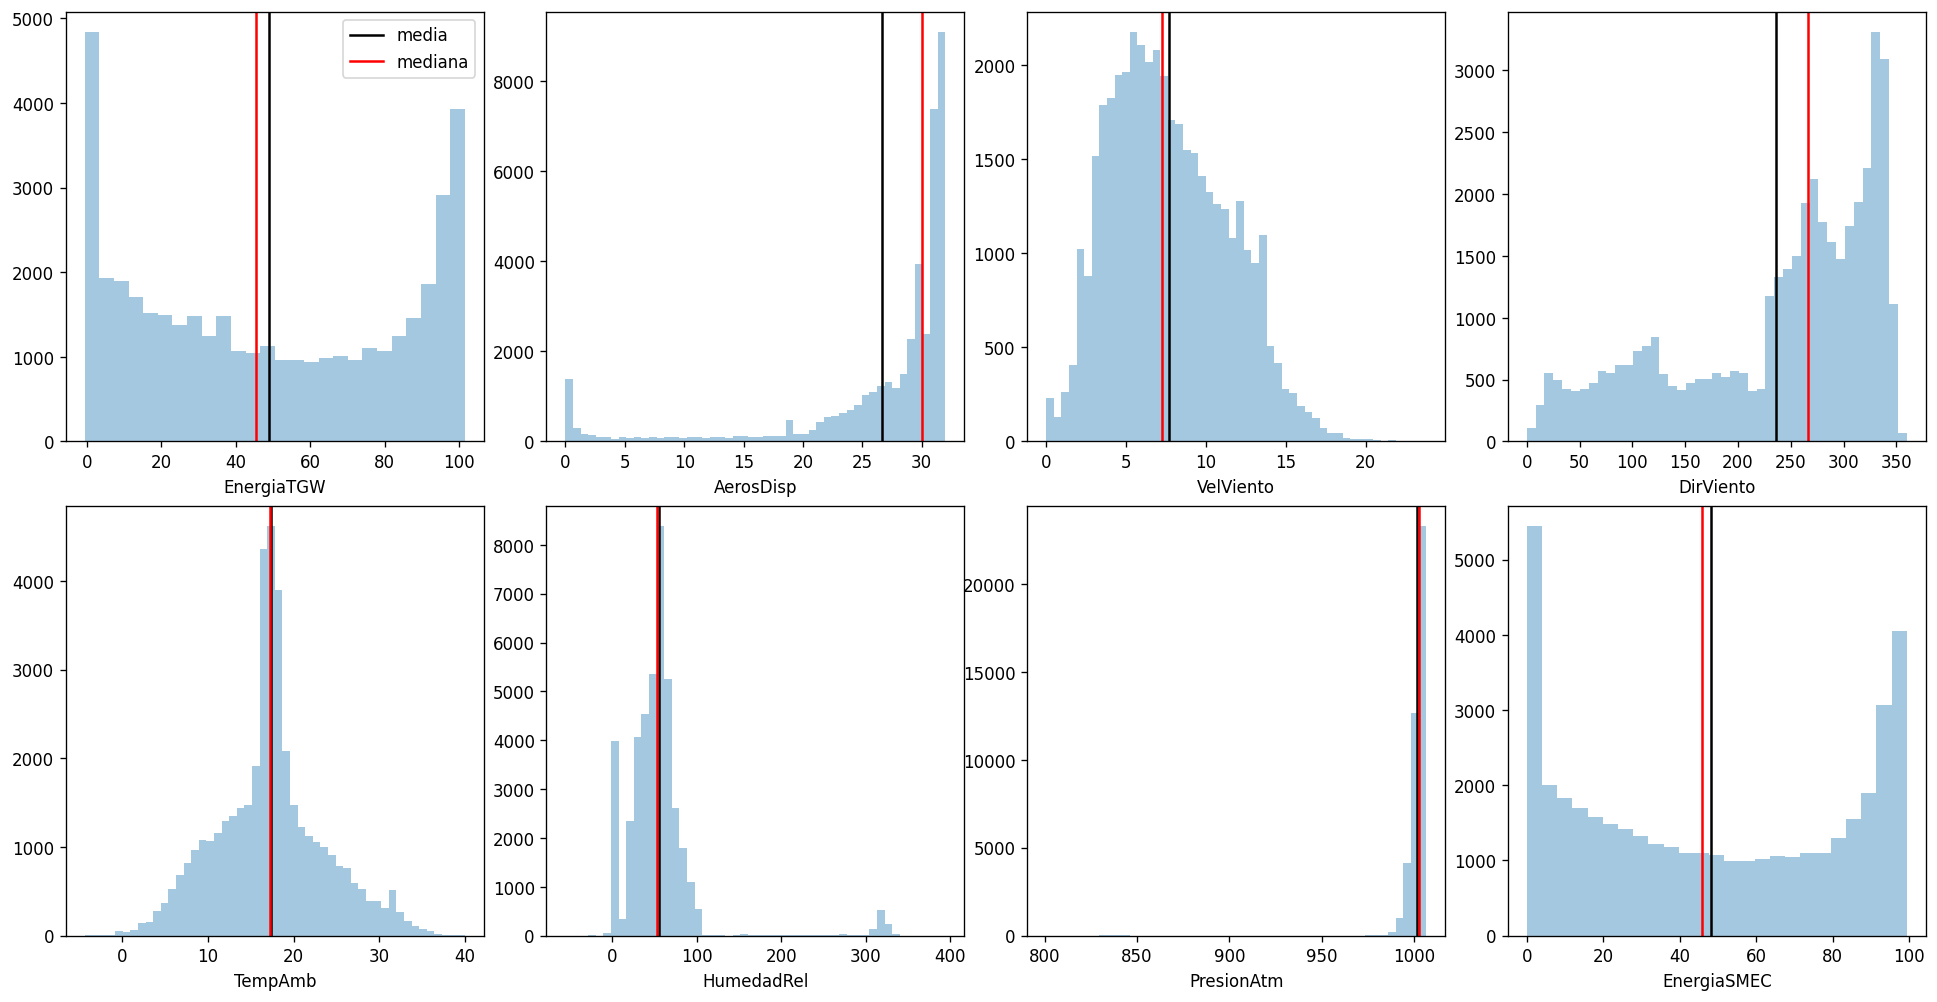

In [123]:
# Distribuciones para cada variable numerica
f,ax = plt.subplots(2,4,figsize=(20,10),gridspec_kw={'wspace':0.15,'hspace':0.15})

ax = ax.ravel()
for i,col in enumerate(num_vars):
    sns.distplot(df_clean[col].astype(float),ax=ax[i],kde=False)
    ax[i].axvline(x=df_clean[col].mean(),color='k',label='media')
    ax[i].axvline(x=df_clean[col].median(),color='r',label='mediana')    
# Turn off the last subplot
if len(num_vars) < len(ax):
    ax[len(num_vars)].remove()
   
ax[0].legend();

Como se puede observar en los histogramas el dataframe df_clean al reemplazar los valores inconsistentes de las variables metereológicas e imputarle la media en algunos casos se generan picos en las medias

<Axes: >

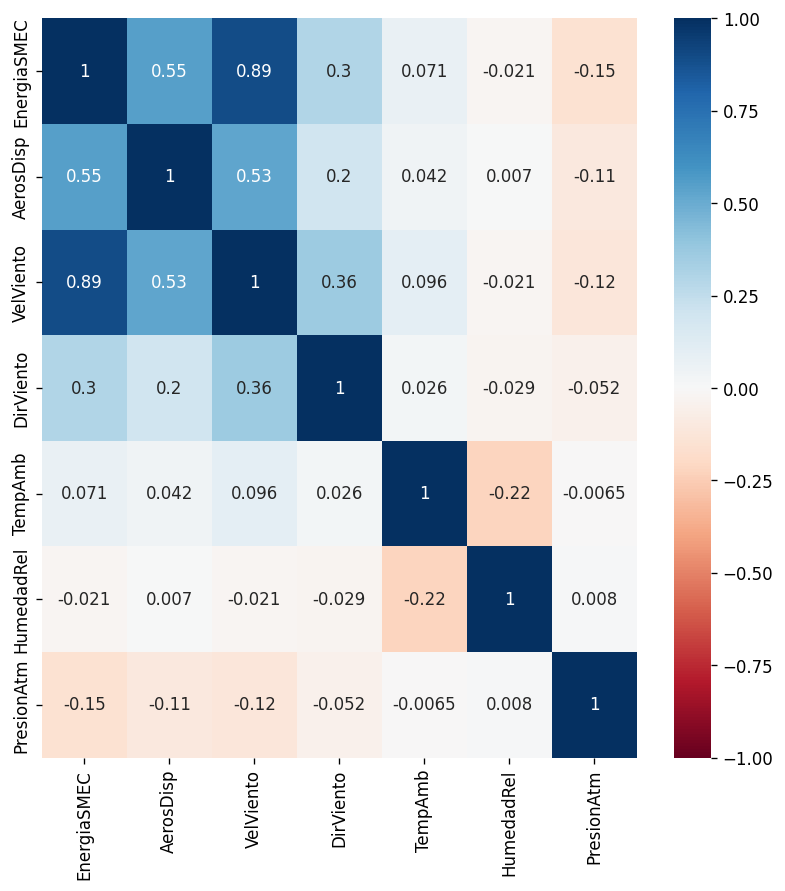

In [124]:
#Matriz de Correlacion
key_vars = ['EnergiaSMEC','AerosDisp','VelViento','DirViento','TempAmb','HumedadRel','PresionAtm']

plt.figure(figsize=(8,8))
sns.heatmap(df_clean[key_vars].corr(),annot=True,cmap='RdBu',vmin=-1)

En la matriz de correlacion se observa claramente la fuerte correlacion entre la Genracion y la velocidad del viento y los Aerogeneradores disponibles, en menor medida la direccion y aun menor la temperatura. Lo cual es totalmente razonable la correlacion con las variables de viento y disponibilidad de maquina, en el caso de la temperatura ambiente la correlacion esta asociada a lo que se conoce en la practica como derrating de temperatura perdida de eficiencia a medida que aumenta la temperatura 

In [125]:
#dejo el archivo en un csv para analizar los datos limpios
df_clean.to_csv('D:\\Documents\\MMA\\1.0 Tesis\\Datos\\df_clean_lac.csv', sep=',', index=False, decimal='.')

### Analisis de datos climaticos historicos extraidos de Meteostat, para las estaciones más cercanas a Achiras

In [126]:
# Import Meteostat library
from meteostat import Stations

# Get nearby weather stations
stations = Stations()

#Aerodromo de Bahia Blanca a 30 Km de La Castellana I
station_ba = stations.nearby(-38.7333, -62.1667) 
station_ba = station_ba.fetch(1)


# Print DataFrame
print(station_ba)


                         name country region    wmo  icao  latitude  \
id                                                                    
87750  Bahia Blanca Aerodrome      AR      B  87750  SAZB  -38.7333   

       longitude  elevation                        timezone hourly_start  \
id                                                                         
87750   -62.1667       75.0  America/Argentina/Buenos_Aires   1939-04-10   

      hourly_end daily_start  daily_end monthly_start monthly_end  distance  
id                                                                           
87750 2024-01-22  1956-02-02 2024-12-30    1956-01-01  2021-01-01       0.0  


In [127]:
# Set time period Mask
start = datetime(2019, 1, 30)
end = datetime(2023, 12, 19)


### Prueba para un rango reducido

In [128]:
# Prueba con un lote de 2 meses oct y nov 2023
#start = datetime(2023, 10, 1)
#end = datetime(2023, 11, 30)

In [129]:
# Create Point for Bahia Blanca
station_ba = 87750  

# Get daily data Bahia Blanca
data_met_ba = Hourly(station_ba, start, end)
#data_met_ba = data_met_ba.normalize()
data_met_ba = data_met_ba.fetch()

# Time Zone Correction Subtract 3 hours from the DateTimeIndex - UTC Buenos Aires
data_met_ba.index = data_met_ba.index - pd.to_timedelta(3, unit='h')

#Wind speed esta en Km/h lo convierto a m/s
data_met_ba['wspd_ms'] = (data_met_ba['wspd'] / 3.6).round(1)

data_met_ba = data_met_ba[[ 'wspd_ms', 'wdir', 'temp']]

data_met_ba.head()

,wspd_ms,wdir,temp
time,,,
2019-01-29 21:00:00,6.2,90.0,20.5
2019-01-29 22:00:00,6.7,87.0,22.5
2019-01-29 23:00:00,6.7,71.0,21.4
2019-01-30 00:00:00,8.7,90.0,19.5
2019-01-30 01:00:00,6.2,42.0,20.1


In [130]:
# Realizo la unión de los DataFrames
df_meteostat = df_clean.merge(data_met_ba, 
                 left_on=['FechaHora'],
                 right_on=['time'],
                 how='left')



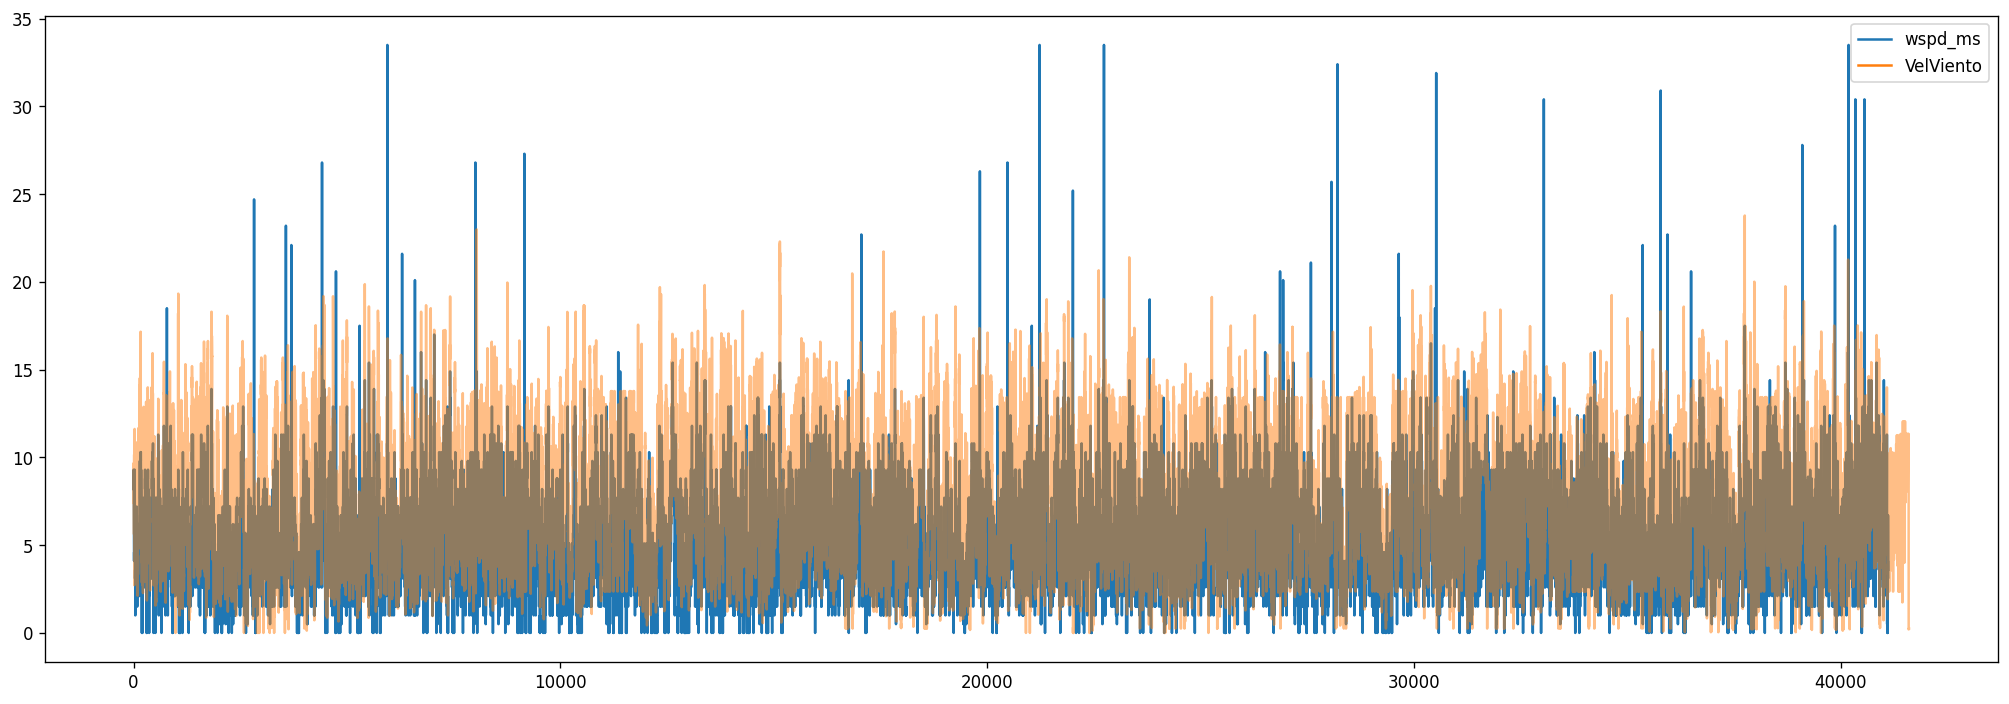

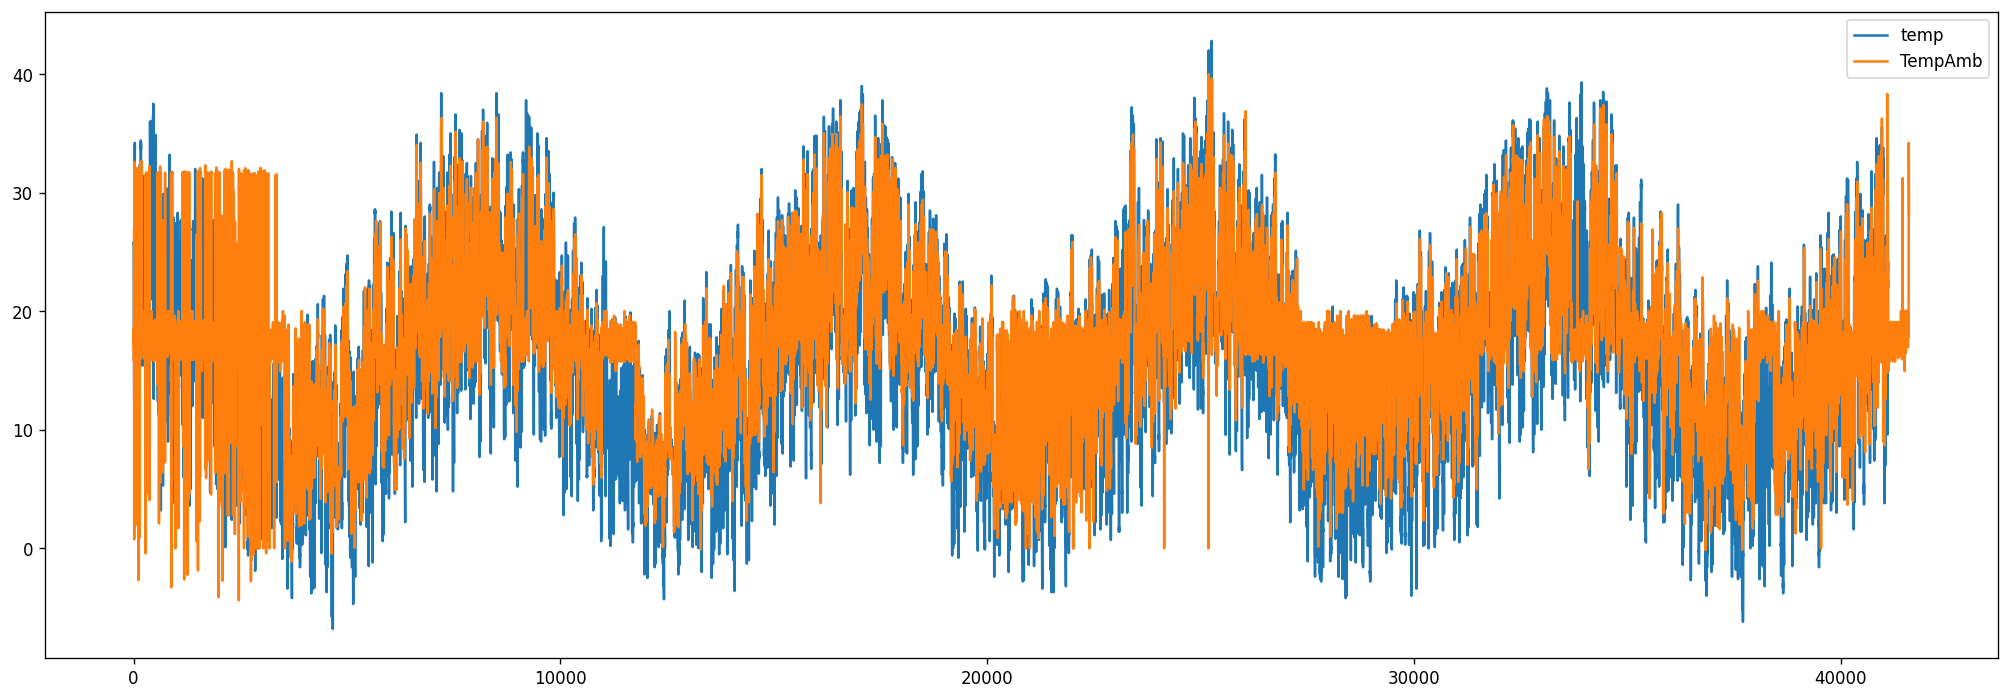

In [131]:

# Set time period Mask
start_m = datetime(2022, 1, 1)
end_m = datetime(2023, 12, 19)

mask = (df_meteostat['FechaHora'] >= start_m) & (df_meteostat['FechaHora'] <= end_m)

# Plotting specific columns
#ax = df_meteostat[mask].plot(y=['wspd_ms', 'VelViento'])  # Plot both columns

ax = df_meteostat.plot(y=['wspd_ms', 'VelViento'])  # Plot both columns


#'wspd_ms_vr', 'VelViento', 


# Adjusting the transparency of a specific line (VelViento) after plotting
lines = ax.get_lines()  # Get the lines in the plot
lines[1].set_alpha(0.5)  # Set transparency (alpha) of the second line (VelViento) to 0.5
#lines[2].set_alpha(0.7)  # Set transparency (alpha) of the second line (VelViento) to 0.5

#df_meteostat.plot(y=['wspd_ms','VelViento'])
df_meteostat.plot(y=['temp','TempAmb'])

#,'TempAmb'

plt.show()




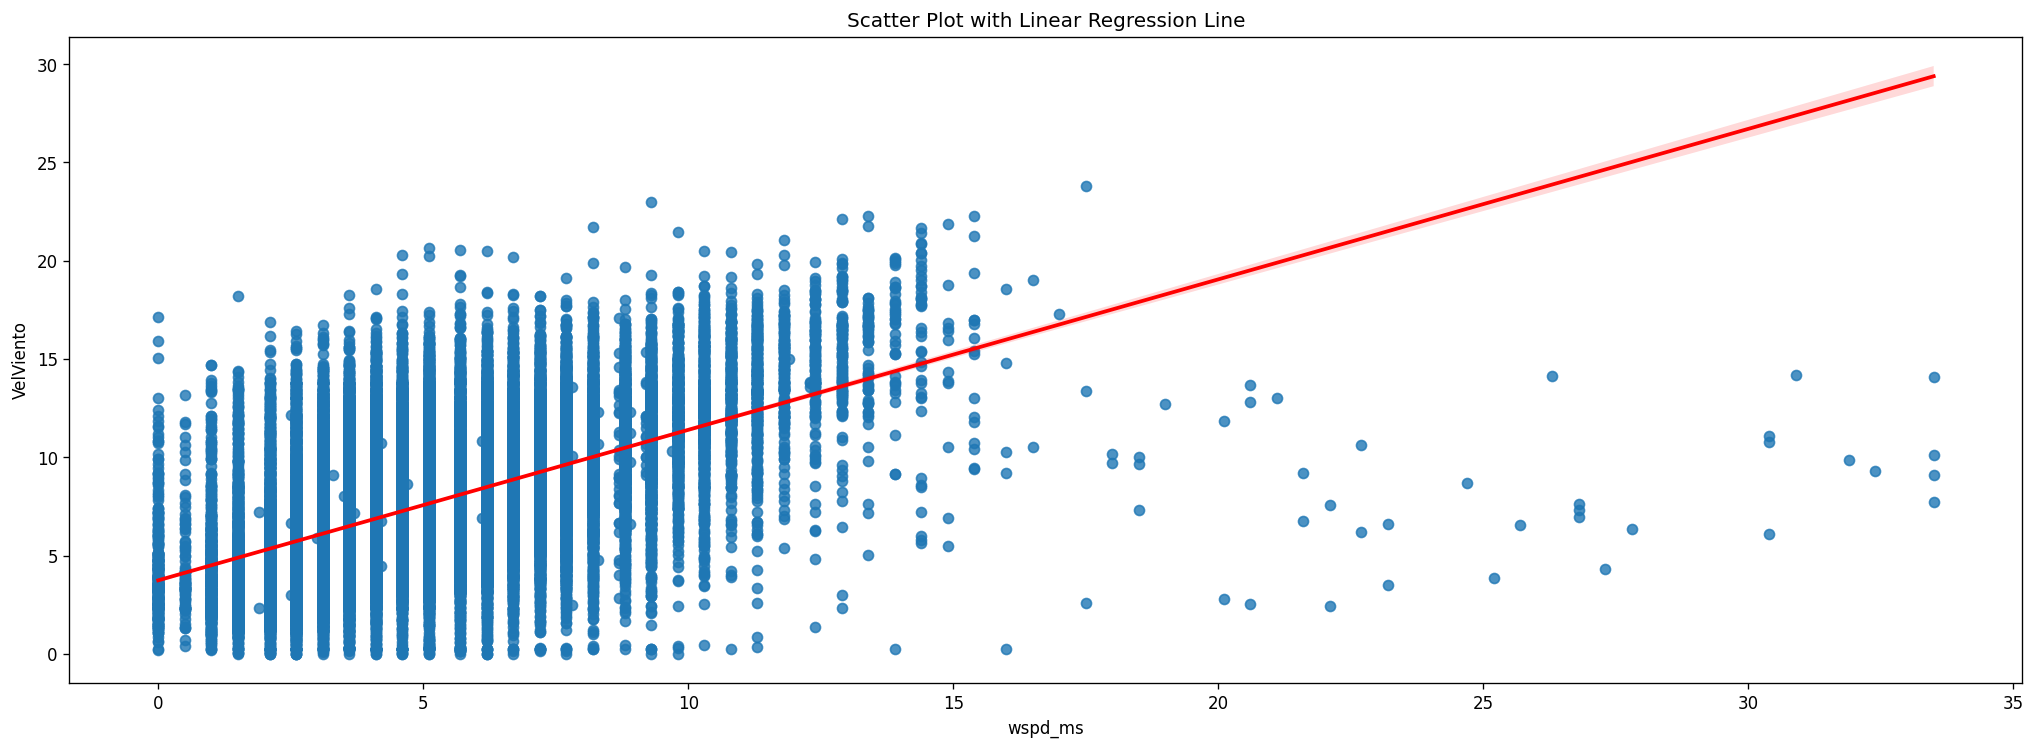

In [132]:
# Scatter plot
sns.regplot(x='wspd_ms', y='VelViento', data=df_meteostat, line_kws={'color': 'red'})
plt.xlabel('wspd_ms')
plt.ylabel('VelViento')
plt.title('Scatter Plot with Linear Regression Line')
plt.show()


#### Distribucion de la velocidad de viento (wspd_ms) extraida de MeteoStat para Bahia Blanca

<Axes: xlabel='wspd_ms'>

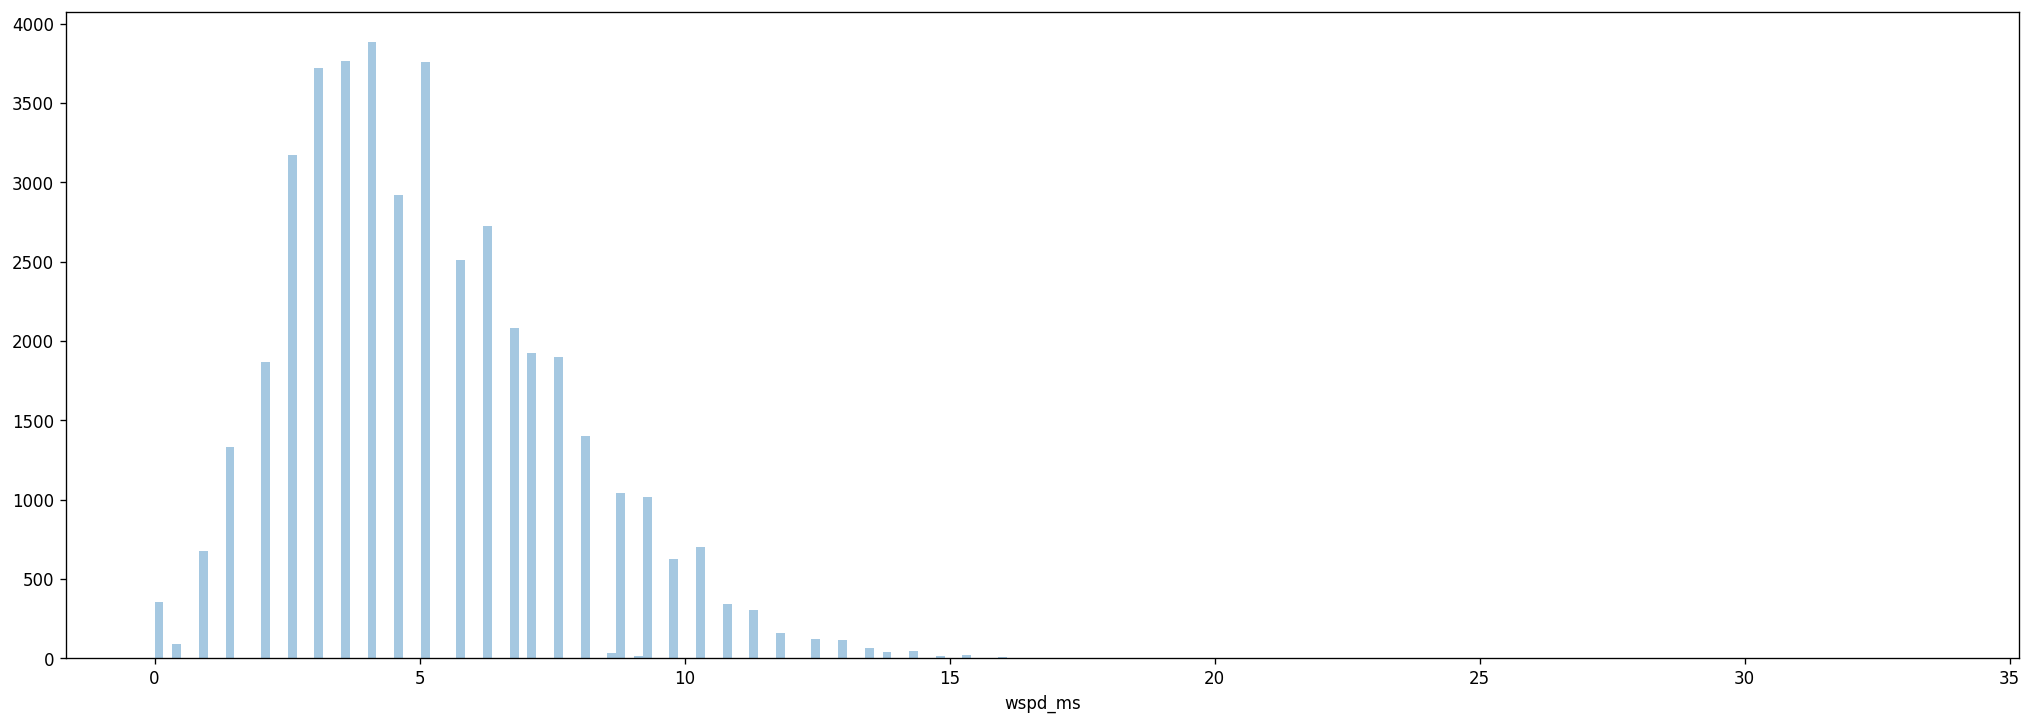

In [133]:
sns.distplot(data_met_ba['wspd_ms'].astype(float),kde=False, bins=200)

#### Distribucion de la velocidad de viento (VelViento) del parque La Castellana

<Axes: xlabel='VelViento'>

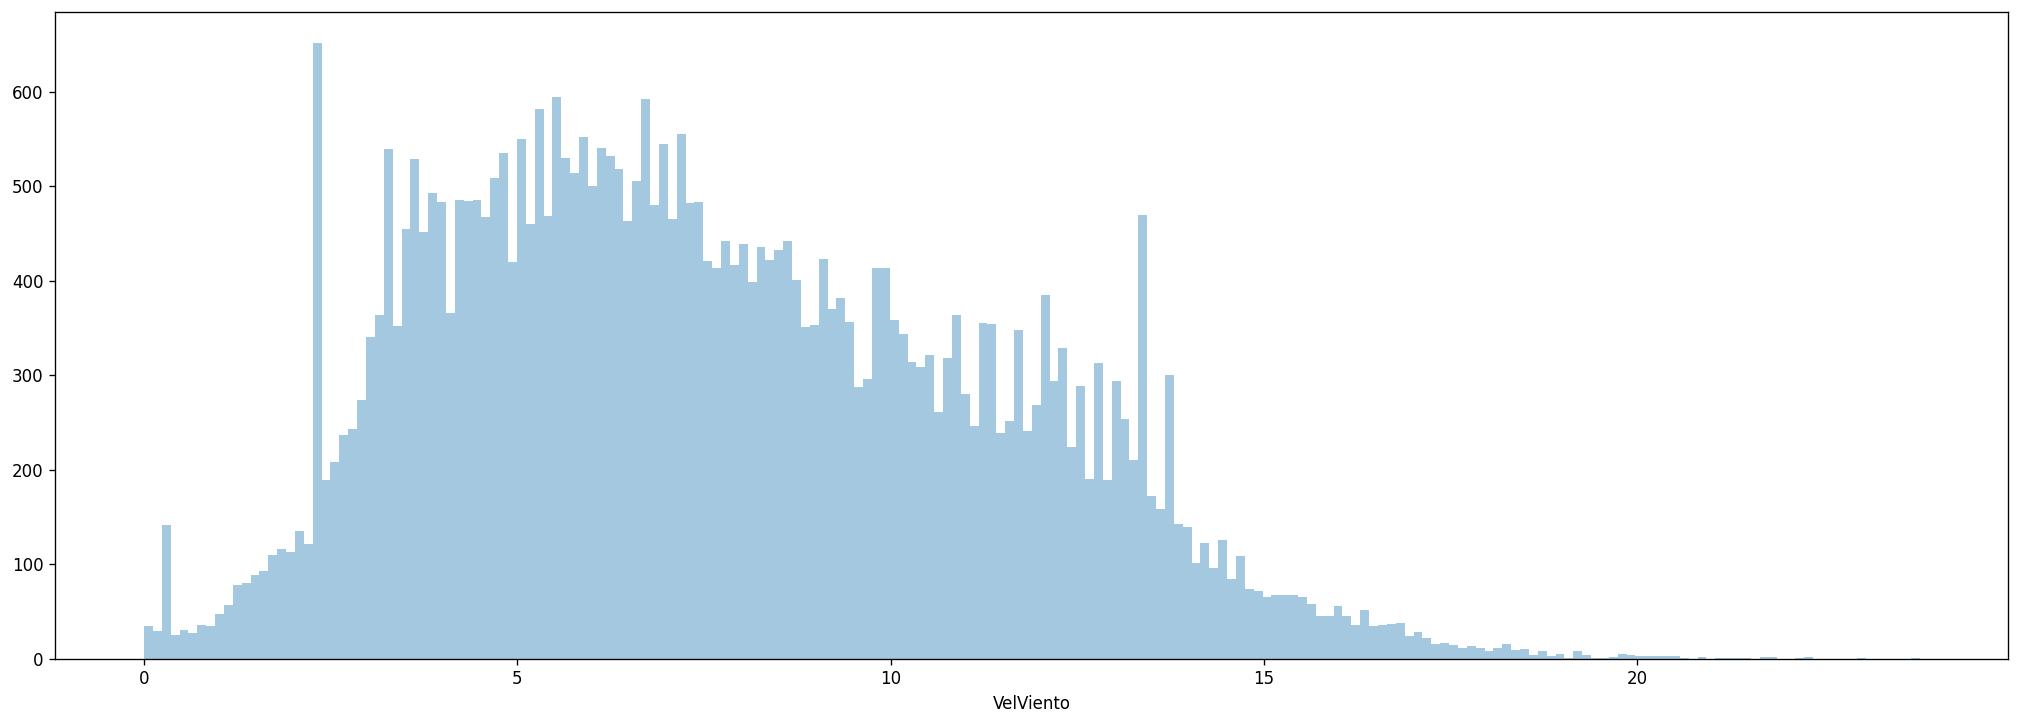

In [134]:
sns.distplot(df_clean['VelViento'].astype(float),kde=False, bins=200)

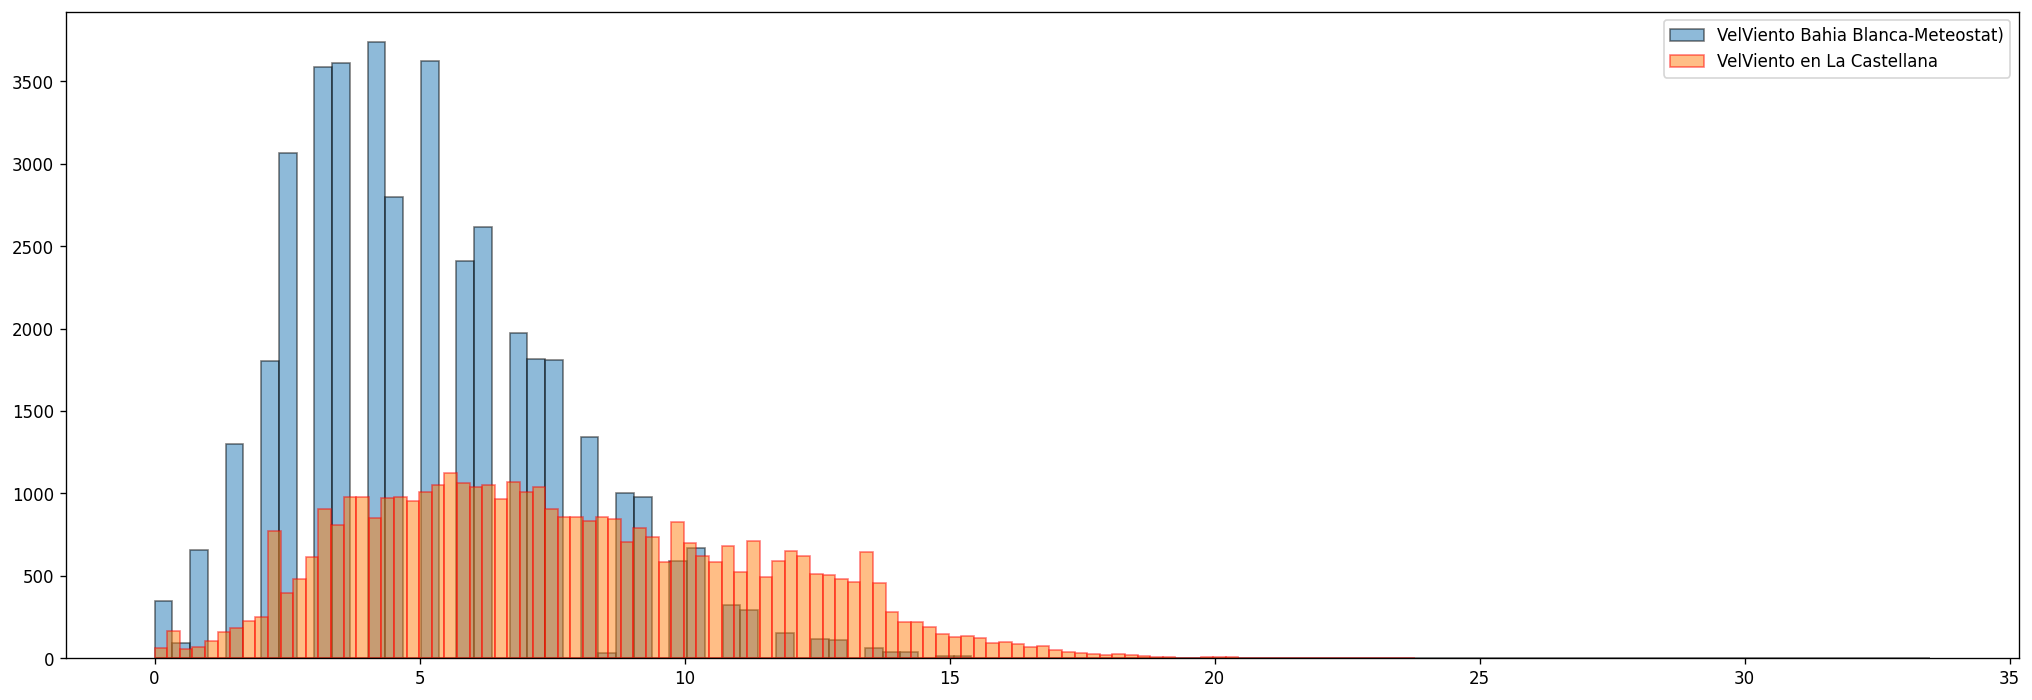

In [135]:

plt.hist(df_meteostat['wspd_ms'], edgecolor='black', alpha=0.5, label='VelViento Bahia Blanca-Meteostat)', bins=100)  # Solid line for Variable 1
plt.hist(df_meteostat['VelViento'], edgecolor='red', alpha=0.5, label='VelViento en La Castellana', bins=100)  # Solid line for Variable 2
plt.legend()
plt.show()

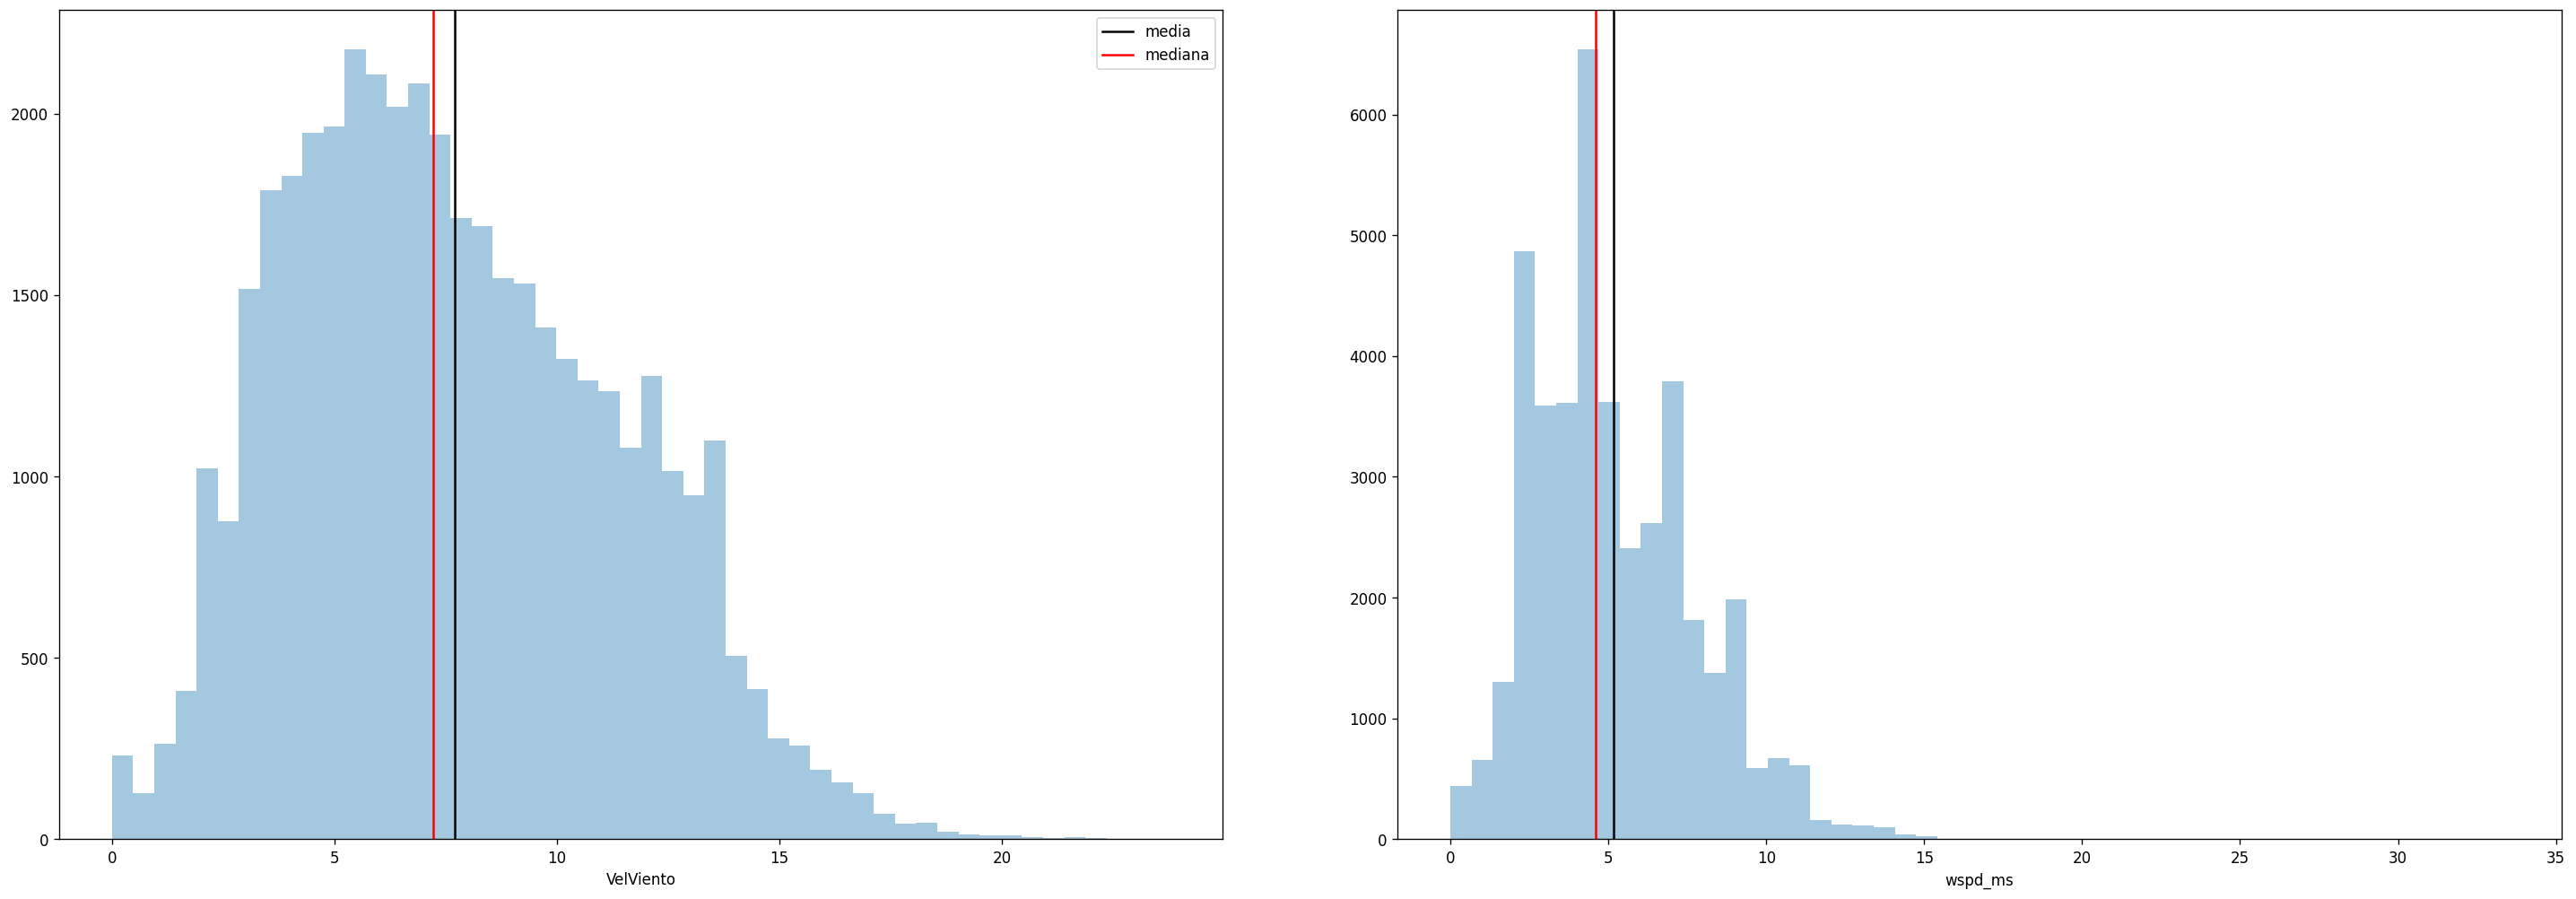

In [136]:
num_vars_met = ['VelViento','wspd_ms'] #,'wspd_ms_rc_ajus'

# Distribuciones para cada variable numerica
f,ax = plt.subplots(1,2,figsize=(30,10),gridspec_kw={'wspace':0.15,'hspace':0.15})

ax = ax.ravel()
for i,col in enumerate(num_vars_met):
    sns.distplot(df_meteostat[col].astype(float),ax=ax[i],kde=False)
    ax[i].axvline(x=df_meteostat[col].mean(),color='k',label='media')
    ax[i].axvline(x=df_meteostat[col].median(),color='r',label='mediana')    
# Turn off the last subplot
if len(num_vars) < len(ax):
    ax[len(num_vars)].remove()
   
ax[0].legend();

<Axes: >

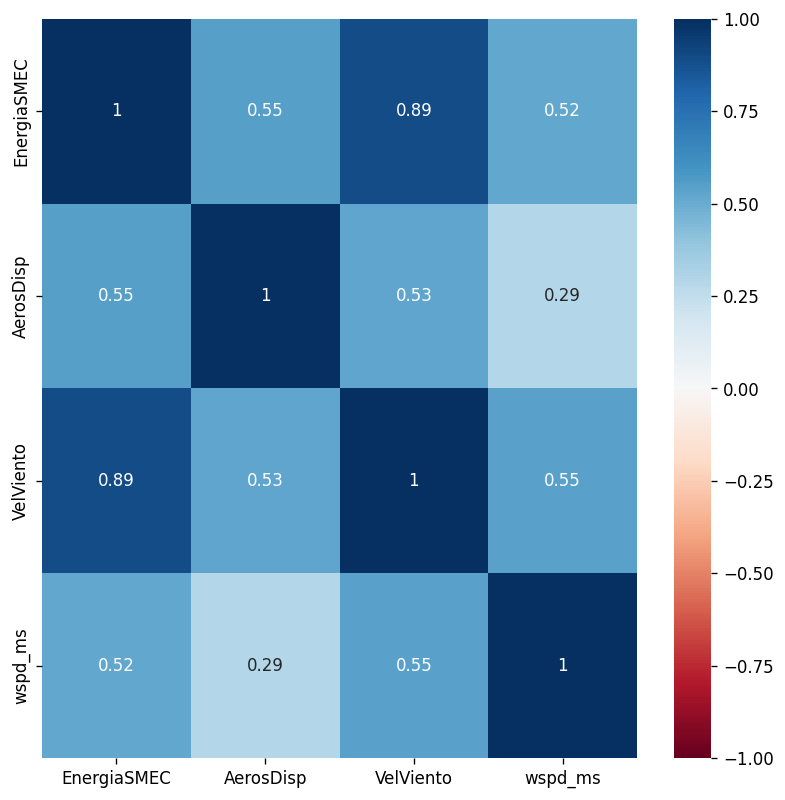

In [137]:
#Matriz de Correlacion
key_vars = ['EnergiaSMEC','AerosDisp','VelViento','wspd_ms']

plt.figure(figsize=(8,8))
sns.heatmap(df_meteostat[key_vars].corr(),annot=True,cmap='RdBu',vmin=-1)

#### ------------------------------------------------------------------------------------------------------------------------------------------
#### Exportación de una versión limpia del dataset


In [140]:
df_clean_ba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41595 entries, 0 to 41594
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   FechaHora          41595 non-null  datetime64[ns]
 1   EnergiaTGW         41595 non-null  float64       
 2   AerosDisp          41595 non-null  float64       
 3   VelViento          41595 non-null  float64       
 4   DirViento          41595 non-null  float64       
 5   TempAmb            41595 non-null  float64       
 6   HumedadRel         41595 non-null  float64       
 7   PresionAtm         41595 non-null  float64       
 8   EnergiaSMEC        41595 non-null  float64       
 9   PronosticoCammesa  29753 non-null  float64       
 10  ErrorPronostico    29753 non-null  float64       
 11  wspd_ms            41105 non-null  float64       
 12  wdir               41105 non-null  float64       
 13  temp               41105 non-null  float64       
dtypes: dat

In [141]:
#Exporto el archivo del dataset limpio

df_clean_ba.to_csv('D:\\Documents\\MMA\\1.0 Tesis\\Time Series\\df_clean_ba.csv', sep=';', index=False, decimal=',')